# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

[INFO] Gemini SDK сконфигурирован. Ключ получен.
Найдено 442 отдельных текстовых блоков
Сформировано 95 строк
Сформировано 78 абзацев

Выбрана стратегия: paragraph. Итоговых блоков: 78
 0 [paragraph] [HEADER]: oe ВИКИПЕДИЯ
 1 [paragraph]: . Вики любит памятники: Сфотографируй памятник, помоги Википедии и выиграй!
 2 [paragraph]: Свободная эициклопедия:
 3 [paragraph] [HEADER]: , узнать больше
 4 [paragraph]: Заглавная страница ‘Содержание
 5 [paragraph] [HEADER]: Valorant
 6 [paragraph]: ‘избранные статьи
 7 [paragraph]: статья
 8 [paragraph]: [править код]
 9 [paragraph]: Материал из Википедии — свободной энциклопедии
10 [paragraph]: Текущие события Пожертвовать,
11 [paragraph]: Valorant (стилизовано как VALORANT) — многопользовательская компьютерная игра, разработанная и издаваемая компанией Riot
12 [paragraph]: ‘Сообщить об ошибке
13 [paragraph]: 2020 года. В августе 2024 года состоялся выход игры на PlayStation 5 и Xbox Series X/S, но без кроссплатформенной игры м
14 [paragraph]: К

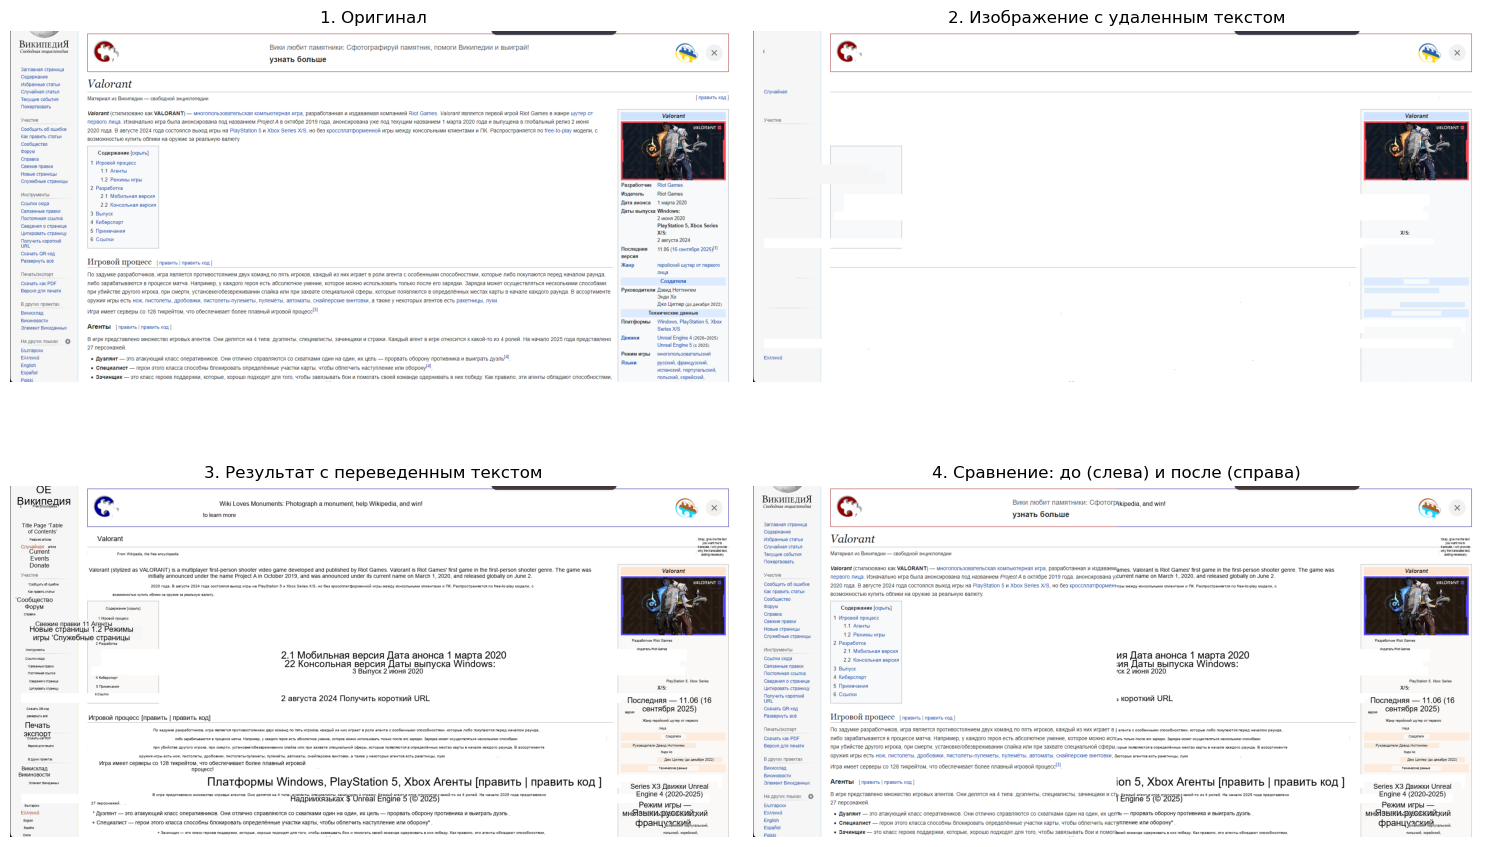


Результат сохранен как: translated_image.jpg

Данные о переводе:
                                             original  \
0                                        oe ВИКИПЕДИЯ   
1   . Вики любит памятники: Сфотографируй памятник...   
2                             Свободная эициклопедия:   
3                                     , узнать больше   
4                      Заглавная страница ‘Содержание   
..                                                ...   
73                          испанский, португальский,   
74                                           Espafiol   
75  + Зачинщик — это класс героев поддержки, котор...   
76                               польский, корейский,   
77                                              Dolce   

                                           translated  confidence  \
0                                        OE Википедия   55.000000   
1   Wiki Loves Monuments: Photograph a monument, h...   87.000000   
2                                  Free En

In [5]:
%matplotlib inline
import pytesseract
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import google.generativeai as genai
from PIL import Image, ImageDraw, ImageFont

# === Конфигурация ===
MERGE_STRATEGY = 'paragraph'
TRANSLATE_WHOLE_BLOCK = True
RESTORE_MISSING_CONJ = True
USE_REST_FALLBACK = True  # использовать REST fallback если SDK не сработал
PLACEHOLDER_KEYS = {'YOUR_GEMINI_API_KEY', 'REPLACE_ME', '', 'PASTE_KEY_HERE'}

PREFER_MODEL = 'gemini-2.0-flash'

def _read_key_from_env():
    for name in ('GEMINI_API_KEY', 'GOOGLE_API_KEY', 'API_KEY', 'GEMINI_KEY'):
        v = os.getenv(name)
        if v:
            v = v.strip().strip('\'"')
            if v and v not in PLACEHOLDER_KEYS:
                return v
    return None

def _read_key_from_dotenv():
    try:
        with open('.env', 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                if line.startswith('export '):
                    line = line[len('export '):]
                if '=' not in line:
                    continue
                k, v = line.split('=', 1)
                k = k.strip()
                v = v.strip().strip('\'"')
                if k in ('GEMINI_API_KEY', 'GOOGLE_API_KEY', 'API_KEY', 'GEMINI_KEY') and v and v not in PLACEHOLDER_KEYS:
                    os.environ[k] = v
                    return v
    except Exception:
        pass
    return None

def _read_key_from_files():
    for path in ('api_key.txt', 'gemini_api_key.txt', '.api_key'):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                v = f.read().strip().strip('\'"')
                if v and v not in PLACEHOLDER_KEYS:
                    return v
        except Exception:
            continue
    return None

def _load_api_key():
    return _read_key_from_env() or _read_key_from_dotenv() or _read_key_from_files()

def _configure_gemini():
    env_key = _load_api_key()
    if not env_key:
        print('[ВНИМАНИЕ] Не найден реальный API ключ. Установите GEMINI_API_KEY/GOOGLE_API_KEY или положите ключ в .env или api_key.txt.')
        print('  PowerShell:  $env:GEMINI_API_KEY="ВАШ_КЛЮЧ"  (и ПЕРЕЗАПУСТИТЕ ядро Jupyter)')
        print('  .env пример: GEMINI_API_KEY=ВАШ_КЛЮЧ')
        return False
    try:
        genai.configure(api_key=env_key)
        print('[INFO] Gemini SDK сконфигурирован. Ключ получен.')
        return True
    except Exception as e:
        print('[ОШИБКА] Не удалось сконфигурировать Gemini SDK:', e)
        return False

API_KEY_AVAILABLE = _configure_gemini()

# --- REST fallback ---
try:
    import requests
except ImportError:
    requests = None

def _get_api_key():
    return _load_api_key()

API_KEY_VALUE = _get_api_key()

REST_ENDPOINT_BASE = 'https://generativelanguage.googleapis.com/v1beta/models'
DEFAULT_MODEL = 'gemini-2.0-flash'

def rest_translate_one(text: str, target_language: str = 'английский', model: str = DEFAULT_MODEL) -> str:
    if not API_KEY_VALUE or not requests:
        return text
    url = f"{REST_ENDPOINT_BASE}/{model}:generateContent?key={API_KEY_VALUE}"
    payload = {
        "contents": [
            {"parts": [{"text": (
                f"Переведи на {target_language}. Если нужны служебные слова для естественности — добавь.\n\n{text}" )}]}]
    }
    try:
        r = requests.post(url, json=payload, timeout=30)
        if r.status_code != 200:
            print(f"[REST WARN] status {r.status_code}: {r.text[:200]}")
            return text
        j = r.json()
        # Ответ может содержать candidates[0].content.parts[*].text
        candidates = j.get('candidates') or []
        if not candidates:
            return text
        parts = candidates[0].get('content', {}).get('parts', [])
        out = ' '.join(p.get('text', '') for p in parts).strip()
        return out or text
    except Exception as e:
        print('[REST ERROR]', e)
        return text

# Переопределяем перевод одиночного текста с fallback

def translate_text_with_gemini(text, target_language="английский"):
    if not API_KEY_VALUE:
        return text
    # Сначала пытаемся SDK
    if API_KEY_AVAILABLE:
        try:
            model = genai.GenerativeModel('gemini-2.0-flash')
            prompt = (f"Переведи следующий текст на {target_language}. "
                      f"Если пропущены союзы (и, для, по) — добавь. Без комментариев.\n\n{text}")
            resp = model.generate_content(prompt)
            t = (getattr(resp, 'text', '') or '').strip()
            if t:
                return t
        except Exception as e:
            print('[SDK TRANSLATE ERROR]', e)
    # Fallback REST
    if USE_REST_FALLBACK:
        return rest_translate_one(text, target_language)
    return text

# Пакетный перевод

def translate_blocks(blocks, target_language="английский"):
    if not API_KEY_VALUE:
        return [b['text'] for b in blocks]
    results = []
    for b in blocks:
        translated = translate_text_with_gemini(b['text'], target_language)
        results.append(translated)
    return results

# Путь к Tesseract (настройте под вашу ОС)
pytesseract.pytesseract.tesseract_cmd = r'D:\Downloads\Tesseract\tesseract.exe'  # Для Windows, удалите для Linux/Mac

def merge_text_blocks(boxes, horizontal_threshold=100, vertical_threshold=50):
    """
    Объединяет близко расположенные текстовые блоки в логические группы

    Args:
        boxes: список словарей с информацией о текстовых блоках
        horizontal_threshold: максимальное расстояние по горизонтали для объединения
        vertical_threshold: максимальное расстояние по вертикали для объединения

    Returns:
        список объединенных текстовых блоков
    """
    if not boxes:
        return []

    # Сортируем блоки по координатам (сначала по Y, потом по X)
    sorted_boxes = sorted(boxes, key=lambda b: (b['y'], b['x']))

    merged_blocks = []
    current_group = [sorted_boxes[0]]

    for i in range(1, len(sorted_boxes)):
        current_box = sorted_boxes[i]
        last_in_group = current_group[-1]

        # Вычисляем расстояние между блоками
        horizontal_distance = abs(current_box['x'] - (last_in_group['x'] + last_in_group['width']))
        vertical_distance = abs(current_box['y'] - last_in_group['y'])

        # Проверяем, находятся ли блоки на одной строке или близко по вертикали
        same_line = vertical_distance <= vertical_threshold
        close_horizontally = horizontal_distance <= horizontal_threshold

        # Дополнительная проверка для блоков на одной логической строке
        y_overlap = (min(current_box['y'] + current_box['height'], last_in_group['y'] + last_in_group['height']) >
                    max(current_box['y'], last_in_group['y']))

        # Если блоки близко друг к другу или перекрываются по Y, добавляем в текущую группу
        if (same_line and close_horizontally) or y_overlap:
            current_group.append(current_box)
        else:
            # Иначе завершаем текущую группу и начинаем новую
            if current_group:
                merged_blocks.append(merge_group(current_group))
            current_group = [current_box]

    # Добавляем последнюю группу
    if current_group:
        merged_blocks.append(merge_group(current_group))

    return merged_blocks

def merge_group(group):
    """Объединяет группу текстовых блоков в один блок"""
    if len(group) == 1:
        return group[0]

    # Находим границы объединенного блока
    min_x = min(box['x'] for box in group)
    min_y = min(box['y'] for box in group)
    max_x = max(box['x'] + box['width'] for box in group)
    max_y = max(box['y'] + box['height'] for box in group)

    # Объединяем текст, сортируя по позиции
    group_sorted = sorted(group, key=lambda b: (b['y'], b['x']))
    combined_text = ' '.join(box['text'] for box in group_sorted)

    # Вычисляем среднюю уверенность
    avg_confidence = sum(box['confidence'] for box in group) / len(group)

    return {
        'text': combined_text,
        'x': min_x,
        'y': min_y,
        'width': max_x - min_x,
        'height': max_y - min_y,
        'confidence': avg_confidence,
        'merged_count': len(group)  # Количество объединенных блоков
    }

def translate_text_with_gemini(text, target_language="английский"):
    """Переводит текст используя Gemini API (или возвращает оригинал, если ключ отсутствует)"""
    if not API_KEY_AVAILABLE:
        return text  # без ключа не пытаемся переводить
    try:
        model = genai.GenerativeModel('gemini-2.0-flash-exp')
        prompt = f"""Переведи следующий текст на {target_language}.
Если в тексте пропущены союзы или предлоги (например, "и", "для", "по"), добавь их для естественности перевода.
Отвечай только переведенным текстом без дополнительных объяснений:\n\n{text}"""
        response = model.generate_content(prompt)
        return (response.text or '').strip() or text
    except Exception as e:
        print(f"Ошибка перевода (single): {e}")
        return text

def get_background_color(img, x, y, w, h):
    """Получает преобладающий цвет фона в области вокруг текста"""
    # Расширяем область для анализа фона
    margin = 10
    x_start = max(0, x - margin)
    y_start = max(0, y - margin)
    x_end = min(img.shape[1], x + w + margin)
    y_end = min(img.shape[0], y + h + margin)

    # Создаем маску для области без текста
    region = img[y_start:y_end, x_start:x_end]

    # Анализируем края региона для определения фонового цвета
    edges = np.concatenate([
        region[0, :].reshape(-1, 3),  # верхний край
        region[-1, :].reshape(-1, 3),  # нижний край
        region[:, 0].reshape(-1, 3),  # левый край
        region[:, -1].reshape(-1, 3)  # правый край
    ])

    # Возвращаем медианный цвет краев
    return np.median(edges, axis=0).astype(int)

def remove_text_from_image(img, boxes):
    """Заменяет текст в боксах фоновым цветом"""
    img_cleaned = img.copy()

    for box in boxes:
        x, y, w, h = box['x'], box['y'], box['width'], box['height']

        # Получаем фоновый цвет
        bg_color = get_background_color(img, x, y, w, h)

        # Заполняем область фоновым цветом
        cv2.rectangle(img_cleaned, (x, y), (x + w, y + h), bg_color.tolist(), -1)

        # Дополнительно применяем размытие для более естественного вида
        roi = img_cleaned[y:y+h, x:x+w]
        roi_blurred = cv2.GaussianBlur(roi, (5, 5), 0)
        img_cleaned[y:y+h, x:x+w] = roi_blurred

    return img_cleaned

def add_translated_text(img, boxes, translated_texts, font_scale=0.8):
    """Добавляет переведенный текст на изображение"""
    img_with_translation = img.copy()

    # Конвертируем в PIL для лучшей работы с текстом
    img_pil = Image.fromarray(cv2.cvtColor(img_with_translation, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)

    # Пытаемся загрузить шрифт (если не получается, используем стандартный)
    try:
        font_size = 16
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    for i, (box, translated_text) in enumerate(zip(boxes, translated_texts)):
        if not translated_text.strip():
            continue

        x, y, w, h = box['x'], box['y'], box['width'], box['height']

        # Автоматически подбираем размер шрифта
        font_size = max(8, min(h - 4, w // max(1, len(translated_text)) * 2 + 8))
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except:
            font = ImageFont.load_default()

        # Разбиваем длинный текст на строки
        words = translated_text.split()
        lines = []
        current_line = ""

        for word in words:
            test_line = current_line + " " + word if current_line else word
            bbox = draw.textbbox((0, 0), test_line, font=font)
            text_width = bbox[2] - bbox[0]

            if text_width <= w - 4:
                current_line = test_line
            else:
                if current_line:
                    lines.append(current_line)
                current_line = word

        if current_line:
            lines.append(current_line)

        # Вычисляем позицию для центрирования текста
        line_height = font_size + 2
        total_height = len(lines) * line_height
        start_y = y + (h - total_height) // 2

        # Рисуем каждую строку
        for line_idx, line in enumerate(lines):
            if start_y + line_idx * line_height < y + h:
                bbox = draw.textbbox((0, 0), line, font=font)
                text_width = bbox[2] - bbox[0]
                text_x = x + (w - text_width) // 2
                text_y = start_y + line_idx * line_height

                # Рисуем текст с контуром для лучшей читаемости
                for dx, dy in [(-1,-1), (-1,1), (1,-1), (1,1)]:
                    draw.text((text_x+dx, text_y+dy), line, font=font, fill=(255, 255, 255))
                draw.text((text_x, text_y), line, font=font, fill=(0, 0, 0))

    # Конвертируем обратно в OpenCV формат
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def smart_merge_by_context(boxes, img_height, img_width):
    """
    Интеллектуальное объединение текста с учетом контекста и восстановления пропущенных слов
    """
    if not boxes:
        return []

    # Группируем блоки по строкам (с учетом Y координат)
    lines = []
    current_line = []

    sorted_boxes = sorted(boxes, key=lambda b: (b['y'], b['x']))

    for box in sorted_boxes:
        if not current_line:
            current_line = [box]
        else:
            # Проверяем, находится ли блок на той же строке
            last_box = current_line[-1]
            y_diff = abs(box['y'] - last_box['y'])

            if y_diff <= 20:  # Тот же уровень
                current_line.append(box)
            else:
                # Новая строка
                if current_line:
                    lines.append(current_line)
                current_line = [box]

    if current_line:
        lines.append(current_line)

    # Объединяем блоки в каждой строке
    merged_lines = []
    for line in lines:
        if len(line) == 1:
            merged_lines.append(line[0])
        else:
            # Сортируем по X координате
            line_sorted = sorted(line, key=lambda b: b['x'])

            # Создаем объединенный блок
            min_x = min(box['x'] for box in line_sorted)
            min_y = min(box['y'] for box in line_sorted)
            max_x = max(box['x'] + box['width'] for box in line_sorted)
            max_y = max(box['y'] + box['height'] for box in line_sorted)

            # Объединяем текст с проверкой расстояний
            combined_text_parts = []
            for i, box in enumerate(line_sorted):
                combined_text_parts.append(box['text'])

                # Проверяем, нужно ли добавить пропущенное слово между блоками
                if i < len(line_sorted) - 1:
                    next_box = line_sorted[i + 1]
                    gap = next_box['x'] - (box['x'] + box['width'])

                    # Если большой промежуток и подходящий контекст, добавляем "и"
                    if (gap > 50 and
                        any(word in box['text'].lower() for word in ['алгоритм', 'компонент', 'справочник']) and
                        any(word in next_box['text'].lower() for word in ['компонент', 'для', 'конструктор'])):
                        combined_text_parts.append('и')

            combined_text = ' '.join(combined_text_parts)
            avg_confidence = sum(box['confidence'] for box in line_sorted) / len(line_sorted)

            merged_block = {
                'text': combined_text,
                'x': min_x,
                'y': min_y,
                'width': max_x - min_x,
                'height': max_y - min_y,
                'confidence': avg_confidence,
                'merged_count': len(line_sorted)
            }
            merged_lines.append(merged_block)

    return merged_lines

def build_dataframe_from_tesseract(data):
    """Создаем DataFrame из словаря pytesseract.image_to_data с очисткой."""
    df = pd.DataFrame(data)
    # Приводим conf к числу и фильтруем
    df['conf'] = pd.to_numeric(df['conf'], errors='coerce').fillna(-1)
    df = df[df['conf'] > 0]
    # Чистим текст
    df['text'] = df['text'].fillna('').str.strip()
    df = df[df['text'] != '']
    # Добавляем высоту как proxy размера шрифта
    df['font_size'] = df['height']
    return df

def group_words_to_lines(df, min_words_in_line=1):
    """Группируем слова в строки по (block_num, par_num, line_num)."""
    if df.empty:
        return []
    lines = []
    group_cols = ['block_num', 'par_num', 'line_num']
    for (b, p, l), g in df.groupby(group_cols):
        g_sorted = g.sort_values('left')
        words = g_sorted['text'].tolist()
        if len(words) < min_words_in_line:
            continue
        text = ' '.join(words)
        x = int(g_sorted['left'].min())
        y = int(g_sorted['top'].min())
        w = int((g_sorted['left'] + g_sorted['width']).max() - x)
        h = int((g_sorted['top'] + g_sorted['height']).max() - y)
        avg_conf = float(g_sorted['conf'].mean())
        font_size = float(g_sorted['font_size'].median())
        lines.append({
            'text': text,
            'x': x,
            'y': y,
            'width': w,
            'height': h,
            'confidence': avg_conf,
            'font_size': font_size,
            'merged_count': len(words),
            'type': 'line'
        })
    # Сортируем по вертикали
    lines.sort(key=lambda r: (r['y'], r['x']))
    return lines

def horizontal_overlap(a, b):
    """Возвращает коэффициент горизонтального перекрытия двух боксов (0..1)."""
    ax1, ax2 = a['x'], a['x'] + a['width']
    bx1, bx2 = b['x'], b['x'] + b['width']
    inter = max(0, min(ax2, bx2) - max(ax1, bx1))
    return inter / max(1, min(a['width'], b['width']))

def merge_lines_to_paragraphs(lines, font_tolerance=0.30, vertical_gap_ratio=1.1, min_overlap=0.45):
    """Объединяем строки в абзацы по близости размеров шрифта, перекрытию и вертикальному интервалу."""
    if not lines:
        return []
    # Сортируем по Y
    lines_sorted = sorted(lines, key=lambda r: (r['y'], r['x']))
    paragraphs = []
    current = [lines_sorted[0]]
    for line in lines_sorted[1:]:
        prev = current[-1]
        font_ok = abs(line['font_size'] - prev['font_size']) <= font_tolerance * max(line['font_size'], prev['font_size'])
        gap = line['y'] - (prev['y'] + prev['height'])
        gap_ok = gap <= vertical_gap_ratio * max(prev['font_size'], line['font_size'])
        overlap = horizontal_overlap(prev, line)
        overlap_ok = overlap >= min_overlap or (min(prev['width'], line['width']) > 0.8 * max(prev['width'], line['width']))
        if font_ok and gap_ok and overlap_ok:
            current.append(line)
        else:
            paragraphs.append(_finalize_paragraph(current))
            current = [line]
    if current:
        paragraphs.append(_finalize_paragraph(current))
    return paragraphs

def _finalize_paragraph(lines_group):
    x = min(l['x'] for l in lines_group)
    y = min(l['y'] for l in lines_group)
    x2 = max(l['x'] + l['width'] for l in lines_group)
    y2 = max(l['y'] + l['height'] for l in lines_group)
    text = ' '.join(l['text'] for l in lines_group)
    avg_conf = sum(l['confidence'] for l in lines_group) / len(lines_group)
    median_font = np.median([l['font_size'] for l in lines_group])
    return {
        'text': text,
        'x': x,
        'y': y,
        'width': x2 - x,
        'height': y2 - y,
        'confidence': avg_conf,
        'font_size': median_font,
        'merged_count': sum(l['merged_count'] for l in lines_group),
        'lines_in_par': len(lines_group),
        'type': 'paragraph'
    }

def detect_headings(paragraphs, heading_factor=1.35):
    """Помечаем абзацы как заголовки, если их размер шрифта существенно больше медианы."""
    if not paragraphs:
        return paragraphs
    sizes = [p['font_size'] for p in paragraphs if p.get('font_size')]
    if not sizes:
        return paragraphs
    median_size = np.median(sizes)
    for p in paragraphs:
        p['is_heading'] = p['font_size'] >= heading_factor * median_size
    return paragraphs

# Переопределяем функцию перевода с опцией перевода списка блоков целиком

def translate_blocks(blocks, target_language="английский"):
    if not API_KEY_VALUE:
        return [b['text'] for b in blocks]
    results = []
    for b in blocks:
        translated = translate_text_with_gemini(b['text'], target_language)
        results.append(translated)
    return results

# Модифицируем основной участок, где формируются merged_boxes:
# Загрузка изображения
image_path = r'..\..\valo_wiki.png'  # Замените на ваш файл

# Проверяем существование файла
if not os.path.exists(image_path):
    print(f"Файл {image_path} не найден!")
    print("Пожалуйста, проверьте путь к изображению.")
else:
    img = cv2.imread(image_path)

    if img is None:
        print(f"Не удалось загрузить изображение {image_path}")
        print("Проверьте, что файл является корректным изображением.")
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Для matplotlib

        # Получение данных о bounding boxes (lang='rus+eng' для русского+английского)
        try:
            data = pytesseract.image_to_data(img, lang='rus+eng', output_type=pytesseract.Output.DICT)
        except Exception as e:
            print(f"Ошибка при распознавании текста: {e}")
            print("Убедитесь, что Tesseract установлен и путь к нему указан правильно.")
            data = None

        if data:
            # Фильтрация только блоков с текстом (confidence > 30 для лучшего качества)
            n_boxes = len(data['text'])
            boxes = []
            for i in range(n_boxes):
                if int(data['conf'][i]) > 30:  # Повышенный порог уверенности
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    text = data['text'][i].strip()
                    if text and len(text) > 1:  # Добавляем только непустой текст длиннее 1 символа
                        boxes.append({'text': text, 'x': x, 'y': y, 'width': w, 'height': h, 'confidence': data['conf'][i]})

            print(f"Найдено {len(boxes)} отдельных текстовых блоков")
            # Преобразуем boxes в DataFrame для продвинутых стратегий
            raw_df = pd.DataFrame(boxes)
            raw_df['left'] = raw_df['x']
            raw_df['top'] = raw_df['y']
            raw_df['font_size'] = raw_df['height']

            # Базовые строки (если есть исходный DataFrame из tesseract — переиспользуем):
            try:
                df_full = build_dataframe_from_tesseract(data)
            except Exception:
                df_full = None

            line_blocks = []
            paragraph_blocks = []

            if df_full is not None and not df_full.empty:
                line_blocks = group_words_to_lines(df_full)
                paragraph_blocks = merge_lines_to_paragraphs(line_blocks)
                paragraph_blocks = detect_headings(paragraph_blocks)

            # Отладочная информация
            if line_blocks:
                print(f"Сформировано {len(line_blocks)} строк")
            if paragraph_blocks:
                print(f"Сформировано {len(paragraph_blocks)} абзацев")

            if MERGE_STRATEGY == 'word':
                final_blocks = boxes
            elif MERGE_STRATEGY == 'line' and line_blocks:
                final_blocks = line_blocks
            elif MERGE_STRATEGY == 'paragraph' and paragraph_blocks:
                final_blocks = paragraph_blocks
            elif MERGE_STRATEGY == 'smart':
                smart_merged = smart_merge_by_context(boxes, img_rgb.shape[0], img_rgb.shape[1])
                final_blocks = smart_merged
            elif MERGE_STRATEGY == 'auto':
                # Простая эвристика: если есть абзацы и их < слов *0.9 -> берем абзацы, иначе строки
                if paragraph_blocks and len(paragraph_blocks) <= max(1, int(0.9 * len(line_blocks or boxes))):
                    final_blocks = paragraph_blocks
                elif line_blocks:
                    final_blocks = line_blocks
                else:
                    final_blocks = boxes
            else:
                # fallback
                final_blocks = paragraph_blocks or line_blocks or boxes

            print(f"\nВыбрана стратегия: {MERGE_STRATEGY}. Итоговых блоков: {len(final_blocks)}")
            for i, b in enumerate(final_blocks):
                tag = b.get('type', 'raw')
                heading_mark = ' [HEADER]' if b.get('is_heading') else ''
                print(f"{i:2d} [{tag}]{heading_mark}: {b['text'][:120]}")

            # Перевод
            if TRANSLATE_WHOLE_BLOCK:
                translated_texts = translate_blocks(final_blocks, "английский")
            else:
                # построчно/поблочно уже handled в translate_blocks, но оставим опцию
                translated_texts = translate_blocks(final_blocks, "английский")

            # Удаляем текст и вставляем перевод
            img_cleaned = remove_text_from_image(img_rgb, final_blocks)
            img_final = add_translated_text(img_cleaned, final_blocks, translated_texts)
            img_final_rgb = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(15, 10))
            plt.subplot(2, 2, 1)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title('1. Оригинал')

            plt.subplot(2, 2, 2)
            plt.imshow(img_cleaned)
            plt.axis('off')
            plt.title('2. Изображение с удаленным текстом')

            plt.subplot(2, 2, 3)
            plt.imshow(img_final_rgb)
            plt.axis('off')
            plt.title('3. Результат с переведенным текстом')

            # Сравнение до и после
            plt.subplot(2, 2, 4)
            comparison = np.hstack([img_rgb[:, :img_rgb.shape[1]//2],
                                  img_final_rgb[:, img_final_rgb.shape[1]//2:]])
            plt.imshow(comparison)
            plt.axis('off')
            plt.title('4. Сравнение: до (слева) и после (справа)')

            plt.tight_layout()
            plt.show()

            # Сохраняем результат
            result_path = 'translated_image.jpg'
            cv2.imwrite(result_path, img_final)
            print(f"\nРезультат сохранен как: {result_path}")

            # Вывод таблицы с данными
            df_data = []
            for i, (box, translated) in enumerate(zip(final_blocks, translated_texts)):
                df_data.append({
                    'original': box['text'],
                    'translated': translated,
                    'x': box['x'],
                    'y': box['y'],
                    'width': box['width'],
                    'height': box['height'],
                    'confidence': box['confidence'],
                    'merged_count': box.get('merged_count', 1)
                })

            df = pd.DataFrame(df_data)
            print("\nДанные о переводе:")
            print(df[['original', 'translated', 'confidence', 'merged_count']])

        else:
            print("Текст не найден или не прошел фильтрацию по качеству.")